In [19]:
import os
from pathlib import Path

import numpy as np
from ase.io import read
from qtpyt.base.greenfunction import GreenFunction
from qtpyt.basis import Basis
from qtpyt.parallel import comm
from qtpyt.parallel.egrid import GridDesc
from qtpyt.base.selfenergy import DataSelfEnergy as BaseDataSelfEnergy
from qtpyt.surface.principallayer import PrincipalSelfEnergy
from qtpyt.surface.tools import prepare_leads_matrices
from qtpyt.tools import remove_pbc, rotate_couplings, expand_coupling
from qtpyt.projector import expand

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

In [20]:
# class DataSelfEnergy(BaseDataSelfEnergy):
#     def __init__(self, energies, sigma, idx_active, ndim_device):
#         super().__init__(energies, sigma)
#         self.idx_active = idx_active
#         self.ndim_device = ndim_device

#     def retarded(self, energy):
#         sigma_active = super().retarded(energy)
#         sigma_full = np.zeros((self.ndim_device, self.ndim_device), dtype=complex)
#         ia = self.idx_active
#         sigma_full[np.ix_(ia, ia)] = sigma_active
#         return sigma_full

class DataSelfEnergy(BaseDataSelfEnergy):
    """Wrapper"""

    def retarded(self, energy):
        return expand(S_device, super().retarded(energy), index_active_region)

def load(filename):
    return DataSelfEnergy(energies, np.load(filename))

# def load(filename, idx_active, ndim_device):
#     sigma = np.load(filename)  # shape: (len(energies), n_active, n_active)
#     print("sigma shape",sigma.shape)
#     return DataSelfEnergy(energies, sigma, idx_active, ndim_device)

In [21]:
pl_path = Path("../dft/leads/")
cc_path = Path("../dft/device/")
data_folder = "../output/lowdin"
ed_data_folder = "../output/lowdin/ed"
index_active_region = np.load(f"{data_folder}/index_active_region.npy")
ed_self_energy_file = f"{ed_data_folder}/self_energy_with_dcc.npy"
output_folder = "../output/lowdin/ed/vertex_tests"
os.makedirs(output_folder, exist_ok=True)

In [22]:
H_leads_lcao, S_leads_lcao = np.load(pl_path / "hs_pl_k.npy")
H_subdiagonalized, S_subdiagonalized = map(
    lambda m: m.astype(complex), np.load(cc_path / "hs_cc_k.npy")
)

basis_dict = {"Au": 9, "H": 5, "C": 13, "N": 13}

leads_atom = read(pl_path / "leads.xyz")
leads_basis = Basis.from_dictionary(leads_atom, basis_dict)

device_atoms = read(cc_path / "scatt.xyz")
device_basis = Basis.from_dictionary(device_atoms, basis_dict)
S_device = np.eye(len(S_subdiagonalized[0]))

In [23]:
de = 0.01
energies = np.arange(0.0, 0.01 + de / 2.0, de).round(7)
eta = 1e-2

Nr = (1, 5, 3)
unit_cell_rep_in_leads = (5, 5, 3)

In [24]:
kpts_t, h_leads_kii, s_leads_kii, h_leads_kij, s_leads_kij = prepare_leads_matrices(
    H_leads_lcao,
    S_leads_lcao,
    unit_cell_rep_in_leads,
    align=(0, H_subdiagonalized[0, 0, 0]),
)
remove_pbc(device_basis, H_subdiagonalized)
remove_pbc(device_basis, S_subdiagonalized)

# Initialize self-energy list for left and right leads
self_energy = [None, None, None]
self_energy[0] = PrincipalSelfEnergy(
    kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr
)
self_energy[1] = PrincipalSelfEnergy(
    kpts_t, (h_leads_kii, s_leads_kii), (h_leads_kij, s_leads_kij), Nr=Nr, id="right"
)

# Rotate the couplings for the leads based on the specified basis and repetition Nr
rotate_couplings(leads_basis, self_energy[0], Nr)
rotate_couplings(leads_basis, self_energy[1], Nr)

# expand to dimension of scattering
expand_coupling(self_energy[0], len(H_subdiagonalized[0]))
expand_coupling(self_energy[1], len(H_subdiagonalized[0]), id="right")

gf = GreenFunction(
    H_subdiagonalized[0],
    S_subdiagonalized[0],
    selfenergies=[(slice(None), self_energy[0]), (slice(None), self_energy[1])],
    eta=eta,
)

In [25]:
ndim_device = len(H_subdiagonalized[0])
if comm.rank == 0:
    # ed_sigma = load(ed_self_energy_file,index_active_region,ndim_device)
    ed_sigma = load(ed_self_energy_file)
else:
    ed_sigma = None

ed_sigma = comm.bcast(ed_sigma, root=0)
self_energy[2] = ed_sigma

gf.selfenergies.append((slice(None), self_energy[2]))


0.0
0.01


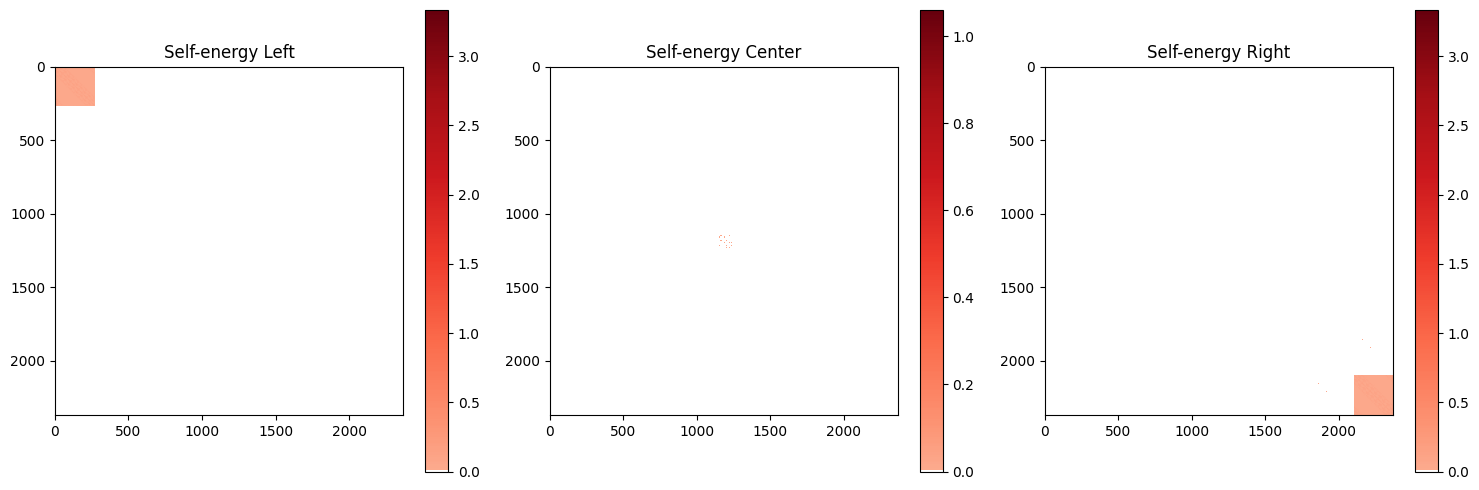

In [38]:
for e in energies:
    print(e)
    se = np.abs(self_energy[2].retarded(e))
    se_l = np.abs(self_energy[0].retarded(e))
    se_r = np.abs(self_energy[1].retarded(e))

# se = se[1100:1230,1100:1230]
matrices = [np.real(se_l), np.real(se), np.real(se_r)]
titles = ['Self-energy Left', 'Self-energy Center', 'Self-energy Right']

maroon_cmap = plt.get_cmap('Reds')
colors = maroon_cmap(np.linspace(0.3, 1, 256))
colors[0] = [1, 1, 1, 1]
custom_cmap = ListedColormap(colors)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for ax, mat, title in zip(axes, matrices, titles):
    mask = (mat == 0)
    mat_plot = mat.copy()
    mat_plot[mask] = mat.min()
    im = ax.imshow(mat_plot, cmap=custom_cmap)
    ax.set_title(title)
    fig.colorbar(im, ax=ax)
plt.tight_layout()
plt.show()

In [43]:
non_zero_elements = se[se != 0]

# Print them
print("Non-zero elements:")
print(non_zero_elements)

non_zero_indices = np.argwhere(se != 0)

# Convert to list of tuples
non_zero_locations = [tuple(idx) for idx in non_zero_indices]

# Print them
print("Non-zero element locations:")
print(non_zero_locations)

Non-zero elements:
[0.08009292 0.302712   0.16345877 0.00911582 0.05758516 0.09128806
 0.04252721 0.302712   0.17324246 0.99664055 0.14829363 0.21262603
 0.34183092 0.1597551  0.16345877 0.99664055 0.09871567 0.75572741
 0.00115642 0.24027027 0.10910365 0.00911582 0.14829363 0.75572741
 0.02823246 0.91426289 0.18438095 0.02028889 0.05758516 0.21262603
 0.00115642 0.91426289 0.11858797 1.05999697 0.26184517 0.09128806
 0.34183092 0.24027027 0.18438095 1.05999697 0.1987851  0.59004208
 0.04252721 0.1597551  0.10910365 0.02028889 0.26184517 0.59004208
 0.20177752]
Non-zero element locations:
[(1119, 1119), (1119, 1147), (1119, 1160), (1119, 1183), (1119, 1196), (1119, 1219), (1119, 1232), (1147, 1119), (1147, 1147), (1147, 1160), (1147, 1183), (1147, 1196), (1147, 1219), (1147, 1232), (1160, 1119), (1160, 1147), (1160, 1160), (1160, 1183), (1160, 1196), (1160, 1219), (1160, 1232), (1183, 1119), (1183, 1147), (1183, 1160), (1183, 1183), (1183, 1196), (1183, 1219), (1183, 1232), (1196, 1119

In [40]:
nonzero_indices = np.nonzero(se)
num_nonzero = len(nonzero_indices[0])

print("Number of nonzero elements:", num_nonzero)
print("Shape of nonzero elements array:", np.array(nonzero_indices).shape)

Number of nonzero elements: 49
Shape of nonzero elements array: (2, 49)


In [28]:
nonzero_indices = np.nonzero(se_r)
num_nonzero = len(nonzero_indices[0])

print("Number of nonzero elements:", num_nonzero)
print("Shape of nonzero elements array:", np.array(nonzero_indices).shape)

Number of nonzero elements: 656100
Shape of nonzero elements array: (2, 656100)


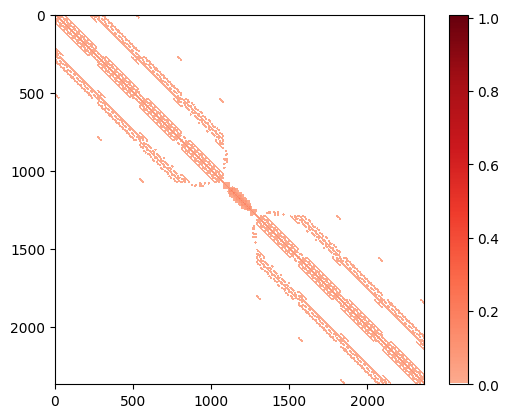

In [29]:
plt.imshow(np.abs(S_subdiagonalized[0]),cmap=custom_cmap)
plt.colorbar()